# Repliaction of work from Coscia & Neffke (2017) -- Network Backboning with Noisy Data (https://arxiv.org/abs/1701.07336)

Author: Alexandra Rottenkolber

Date: 01.07.2022

In [1]:
import os

# packages used by Coscia
import sys, warnings
import numpy as np
import pandas as pd
import networkx as nx
from collections import defaultdict
from scipy.stats import binom, pearsonr, sem

#functions written by Coscia and Neffke 
import backboning_python3_networkx2_Coscia as backboning

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
#read in networks data 
country_attributes = pd.read_csv("../../Backboning_Coscia/backboning/country_networks.csv", sep="\t")

**Information on the data**

`country_networks.csv`: contains the real world networks used in Coscia & Neffke (2017). Business, Flight and Ownership networks are not included due to Data Usage Agreements preventing their sharing. Each column represent a network, either a yearly snapshot (if year is specified in the column name) or agreggated across yeas (if year is not specified in the column name).

# Replication of Coscia & Neffke (2017), Figure 3

In [3]:
#code from Coscia et al (2017) to reproduce figure 3 
toy_table = pd.read_csv("../../Backboning_Coscia/backboning/fig3/toy_net", sep = "\t")
table_nc = backboning.noise_corrected(toy_table, undirected = True)
table_df = backboning.disparity_filter(toy_table, undirected = True)

bb_neffke = backboning.thresholding(table_nc, 4)
bb_vespignani = backboning.thresholding(table_df, 0.66)

print("NC Backbone:")
print(bb_neffke)
print("\n")
print("DF Backbone:")
print(bb_vespignani)

NC Backbone:
   src  trg  nij     score
5    2    3  1.0  0.632653
2    1    4  5.0  0.355932
3    1    5  5.0  0.355932
4    1    6  5.0  0.355932


DF Backbone:
   src  trg  nij     score
0    1    2  2.0  0.666667
2    1    3  2.0  0.666667
4    1    4  5.0  0.705220
6    1    5  5.0  0.705220
8    1    6  5.0  0.705220


Calculating NC score...
Calculating DF score...


# Replication of of Coscia & Neffke (2017), Table 1

In [4]:
#code from Coscia et al (2017) to reproduce Table 1, edited  
import settings_tab1

ndigits = {"cs": 2, "mi": 3, "tr": 3}

print("Noise Corrected\n")

for network in settings_tab1.networks_years:
    obs_variance_cij = pd.DataFrame(columns = ["src", "trg", "score"])
    for year in settings_tab1.networks_years[network]:
        table, _, _ = backboning.read("../../Backboning_Coscia/backboning/country_networks.csv", year)
        nc_table = backboning.noise_corrected(table)
        obs_variance_cij = obs_variance_cij.merge(nc_table[["src", "trg", "score"]], on = ["src", "trg"], how = "right", suffixes = ("", "_%s" % year))
    obs_variance_cij = obs_variance_cij.drop("score", 1).dropna()
    obs_variance_cij["sdev_cij"] = obs_variance_cij.std(axis = 1)
    table, _, _ = backboning.read("../../Backboning_Coscia/backboning/country_networks.csv", network)
    nc_table = backboning.noise_corrected(table)
    nc_table = nc_table[["src", "trg", "sdev_cij"]].merge(obs_variance_cij[["src", "trg", "sdev_cij"]], on = ["src", "trg"])
    nc_table["sdev_cij_x_agg"] = nc_table["sdev_cij_x"].round(decimals = ndigits[network]) + (10 ** -ndigits[network])
    nc_table["sdev_cij_y_agg"] = nc_table["sdev_cij_y"].round(decimals = ndigits[network]) + (10 ** -ndigits[network])
    sdev_cij_y_cnt = nc_table.groupby(by = ["sdev_cij_x_agg", "sdev_cij_y_agg"])["sdev_cij_y"].count().reset_index()
    sdev_cij_y_cnt.sort_values(by = "sdev_cij_y").to_csv("sdev_%s_noise_corrected" % network, index = False, sep = "\t")
    corr = pearsonr(np.log(nc_table["sdev_cij_x"]), np.log(nc_table["sdev_cij_y"]))
    print("%s\t%s\t%s" % (network, corr[0], corr[1]))

Calculating NC score...
Calculating NC score...


Noise Corrected



Calculating NC score...
Calculating NC score...
Calculating NC score...
Calculating NC score...


cs	0.6271381822868225	0.0


Calculating NC score...
Calculating NC score...


tr	0.16151468985500395	6.097655759125164e-101


Calculating NC score...
Calculating NC score...
Calculating NC score...


mi	0.06409881807066904	2.08332120263893e-10


Calculating NC score...
Calculating NC score...


# Replication of of Coscia & Neffke (2017), Table 2

In [5]:
import statsmodels.formula.api as smf

In [6]:
#code from Coscia et al (2017) to reproduce Table 2 -- indicating the improvement in predictive power when using backbones
import settings_tab2

measure_label = {
   "noise_corrected": "Noise-Corrected",
   "disparity_filter": "Disparity Filter",
   "high_salience_skeleton": "High Salience Skeleton",
   "doubly_stochastic": "Doubly Stochastic",
   "maximum_spanning_tree": "Maximum Spanning Tree",
   "naive": "Naive Threshold",
}

country_attributes = pd.read_csv("../../Backboning_Coscia/backboning/country_networks.csv", sep = "\t")
country_population = pd.read_csv("../../Backboning_Coscia/backboning/tab2/country_pop.csv")
country_attributes = country_attributes.merge(country_population, left_on = "src", right_on = "Country Code", how = "left")
country_attributes = country_attributes.rename(columns = {"2014": "src_pop"}).drop("Country Code", 1)
country_attributes = country_attributes.merge(country_population, left_on = "trg", right_on = "Country Code", how = "left")
country_attributes = country_attributes.rename(columns = {"2014": "trg_pop"}).drop("Country Code", 1)
country_distances = pd.read_csv("../../Backboning_Coscia/backboning/tab2/cepii_dista.csv", sep = ";")[["iso_o", "iso_d", "comlang_off", "comlang_ethno", "colony", "comcol", "curcol", "col45", "smctry"]]
country_attributes = country_attributes.merge(country_distances, left_on = ["src", "trg"], right_on = ["iso_o", "iso_d"], how = "left")
country_attributes.drop("iso_o", 1, inplace = True)
country_attributes.drop("iso_d", 1, inplace = True)
country_attributes.rename(columns = {"intensity": "fdi"}, inplace = True)
country_eci = pd.read_csv("../../Backboning_Coscia/backboning/tab2/country_eci.csv", sep = "\t")
country_eci = pd.pivot_table(country_eci, index = "country", columns = "year", values = "eci").reset_index()
country_eci["avg_eci"] = (country_eci[2011] + country_eci[2013]) / 2.0
country_attributes = country_attributes.merge(country_eci[["country", "avg_eci"]], left_on = "src", right_on = "country", how = "left")
country_attributes = country_attributes.rename(columns = {"avg_eci": "src_eci"}).drop("country", 1)
country_attributes = country_attributes.merge(country_eci[["country", "avg_eci"]], left_on = "trg", right_on = "country", how = "left")
country_attributes = country_attributes.rename(columns = {"avg_eci": "trg_eci"}).drop("country", 1)

country_attributes["log_mi"] = np.log(country_attributes["mi"] + 1)
country_attributes["log_cs"] = np.log(country_attributes["cs"] + 1)
country_attributes["log_geodist"] = np.log(country_attributes["geodist"] + 1)
country_attributes["log_src_pop"] = np.log(country_attributes["src_pop"] + 1)
country_attributes["log_trg_pop"] = np.log(country_attributes["trg_pop"] + 1)

backbones = defaultdict(lambda : defaultdict(int))
measure_qualities = defaultdict(list)

for network in settings_tab2.networks:
    table, original_nodes, original_edges = backboning.read("../../Backboning_Coscia/backboning/country_networks.csv", network, undirected = (network == "cs"))
    for measure in settings_tab2.measures:
        edge_table = settings_tab2.measures[measure](table, undirected = (network == "cs"))
        if settings_tab2.fixedges_thresholds[measure][network] != None:
            edge_table_thresholded = backboning.thresholding(edge_table, settings_tab2.fixedges_thresholds[measure][network])
        else:
            edge_table_thresholded = edge_table.copy()
        backbones[measure][network] = edge_table_thresholded   
        if not backbones[measure][network].empty:
            G = nx.from_pandas_edgelist(edge_table_thresholded, "src", "trg")
            if network == "mi":
                tmp_table = backbones[measure][network].merge(country_attributes, on = ["src", "trg"])

                tmp_table["log_mi"] = np.log(tmp_table["mi"] + 1)
                tmp_table["log_geodist"] = np.log(tmp_table["geodist"] + 1)
                tmp_table["log_src_pop"] = np.log(tmp_table["src_pop"] + 1)
                tmp_table["log_trg_pop"] = np.log(tmp_table["trg_pop"] + 1)

                #base_regr = pd.ols(y = np.log(country_attributes["mi"] + 1), x = {"a": country_attributes[["comlang_off", "comlang_ethno", "colony", "comcol", "curcol", "col45", "smctry"]], "b": np.log(country_attributes[["geodist", "src_pop", "trg_pop"]] + 1)}, intercept = True)
                #bb_regr = pd.ols(y = np.log(tmp_table["mi"] + 1), x = {"a": tmp_table[["comlang_off", "comlang_ethno", "colony", "comcol", "curcol", "col45", "smctry"]], "b": np.log(tmp_table[["geodist", "src_pop", "trg_pop"]] + 1)}, intercept = True)

                base_regr = smf.ols('log_mi ~ 1 + comlang_off+comlang_ethno+colony+comcol+curcol+col45+smctry+log_geodist+log_src_pop+log_trg_pop', data = country_attributes).fit()
                bb_regr = smf.ols('log_mi ~ 1 + comlang_off+comlang_ethno+colony+comcol+curcol+col45+smctry+log_geodist+log_src_pop+log_trg_pop', data = tmp_table).fit()

                measure_qualities[measure].append("%1.4f" % (bb_regr.rsquared / base_regr.rsquared))

            elif network == "cs":
                tmp_table = backbones[measure][network].merge(country_attributes, on = ["src", "trg"])

                tmp_table["log_mi"] = np.log(tmp_table["mi"] + 1)
                tmp_table["log_geodist"] = np.log(tmp_table["geodist"] + 1)
                tmp_table["log_src_pop"] = np.log(tmp_table["src_pop"] + 1)
                tmp_table["log_trg_pop"] = np.log(tmp_table["trg_pop"] + 1)

                #base_regr = pd.ols(y = np.log(country_attributes["cs"] + 1), x = {"a": country_attributes[["src_eci", "trg_eci"]], "b": np.log(country_attributes[["geodist"]] + 1)}, intercept = True)
                #bb_regr = pd.ols(y = np.log(tmp_table["cs"] + 1), x = {"a": tmp_table[["src_eci", "trg_eci"]], "b": np.log(tmp_table[["geodist"]] + 1)}, intercept = True)

                base_regr = smf.ols('log_cs ~ 1 + src_eci+trg_eci+log_geodist', data = country_attributes).fit()
                bb_regr = smf.ols('log_cs ~ 1 + src_eci+trg_eci+log_geodist', data = tmp_table).fit()

                measure_qualities[measure].append("%1.4f" % (bb_regr.rsquared / base_regr.rsquared))

for measure in measure_label:
    print("%s & %s\\\\" % (measure_label[measure], " & ".join(measure_qualities[measure])))

Calculating Naive score...
Calculating NC score...
Calculating DF score...
Calculating DST score...
Calculating MST score...
Calculating HSS score...
Calculating Naive score...
Calculating NC score...
Calculating DF score...
Calculating DST score...
Calculating MST score...
Calculating HSS score...
Calculating Naive score...
Calculating NC score...
Calculating DF score...
Calculating DST score...
Calculating MST score...
Calculating HSS score...


Noise-Corrected & 2.2437 & 2.1493\\
Disparity Filter & 1.4082 & 2.0715\\
High Salience Skeleton & 1.6549 & 1.2597\\
Doubly Stochastic & 2.0969 & 1.7054\\
Maximum Spanning Tree & 1.8618 & 0.9722\\
Naive Threshold & 0.6834 & 1.1616\\


# Example: Backboning "noise-corrected"

In [7]:
ix = 0 #0:cs (Country Space -- undirected co-occurrence network), 1:mi (Migration -- directed stock network)

network = settings_tab2.networks[ix]
measure = "noise_corrected"

In [8]:
#read in example network
table, original_nodes, original_edges = backboning.read("../../Backboning_Coscia/backboning/country_networks.csv", network, undirected = (network == "cs"))

In [9]:
table.head() #nij indicates the weight of an edge

,src,trg,nij
0,AGO,ARE,2.666667
3,AGO,BEL,1.000000
5,AGO,BRA,1.666667
6,AGO,CAN,1.000000
7,AGO,CHE,1.000000


In [10]:
original_nodes, original_edges

(165, 12485.0)

In [11]:
edge_table = backboning.noise_corrected(table, undirected = (network == [settings_tab2.networks[ix]]))
edge_table.head()

Calculating NC score...


,src,trg,nij,score,sdev_cij
0,AGO,ARE,2.666667,0.745630,0.100008
41,ALB,ARE,11.666667,-0.093771,0.151022
252,ARG,ARE,13.666667,-0.032788,0.135889
343,ARM,ARE,10.333333,0.077731,0.147410
414,AUS,ARE,11.666667,0.114582,0.135289


In [12]:
if settings_tab2.fixedges_thresholds[measure][network] != None:
    edge_table_thresholded = backboning.thresholding(edge_table, settings_tab2.fixedges_thresholds[measure][network])
    threshold = settings_tab2.fixedges_thresholds[measure][network]
    print(f"Was not NONE. Threshold used is {threshold}.") #set by Coscia et al. Unclear where it comes from.
else:
    print("Was NONE.")
    edge_table_thresholded = edge_table.copy()
backbones[measure][network] = edge_table_thresholded   

Was not NONE. Threshold used is 4.2005.


In [13]:
edge_table_thresholded.head() #This is the backbomes network 

,src,trg,nij,score
0,AGO,ARE,2.666667,0.745630
1551,BRN,ARE,2.666667,0.700684
5912,KWT,ARE,7.333333,0.703176
7769,OMN,ARE,16.666667,0.503369
8610,QAT,ARE,9.000000,0.667393


In [14]:
#Original nodes and edges after thresholding 

original_nodes_thresh = len(set(edge_table_thresholded["src"]) | set(edge_table_thresholded["trg"]))
original_edges_thresh = edge_table_thresholded.shape[0] / 2 #/2 because undirected network

original_nodes_thresh, original_edges_thresh

(154, 682.0)

In [15]:
#Difference pre- and after thresholding 
original_nodes-original_nodes_thresh, original_edges-original_edges_thresh

(11, 11803.0)

In [16]:
G_threshold = nx.from_pandas_edgelist(edge_table_thresholded, "src", "trg")
G = nx.from_pandas_edgelist(edge_table, "src", "trg")

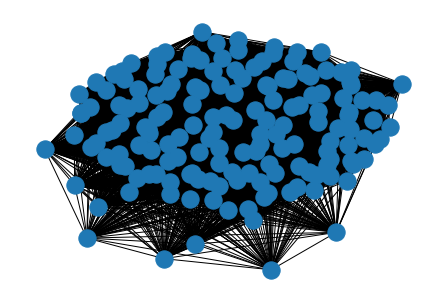

In [17]:
nx.draw(G)

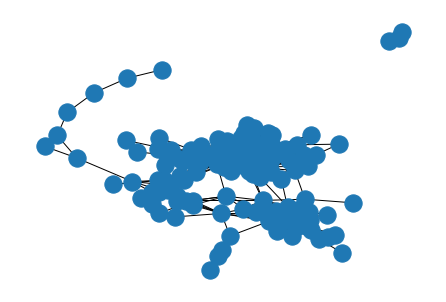

In [18]:
nx.draw(G_threshold)

# Comparison of different backboing techniques

In [19]:
ix = 0 #0:cs (Country Space -- undirected co-occurrence network), 1:mi (Migration -- directed stock network)

network = settings_tab2.networks[ix]
network

'cs'

In [20]:
def backbone_network(network, measure): 
    
    table, original_nodes, original_edges = backboning.read("../../Backboning_Coscia/backboning/country_networks.csv", network, undirected = (network == "cs"))
    
    edge_table = settings_tab2.measures[measure](table, undirected = (network == "cs")) # backboning takes place here 
    
    if settings_tab2.fixedges_thresholds[measure][network] != None:        
        edge_table_thresholded = backboning.thresholding(edge_table, settings_tab2.fixedges_thresholds[measure][network])
        threshold = settings_tab2.fixedges_thresholds[measure][network]
        print(f"Threshold used is {threshold}.\n") #set by Coscia et al. Unclear where it comes from.
    else:
        print("Threshold was NONE.")
        edge_table_thresholded = edge_table.copy()
        
    
    original_nodes_thresh = len(set(edge_table_thresholded["src"]) | set(edge_table_thresholded["trg"]))
    original_edges_thresh = edge_table_thresholded.shape[0]

    print(f"Number of original nodes pre-thresholding: {original_nodes}")
    print(f"Number of original edges pre-thresholding: {int(original_edges)} \n")
    print(f"Number of original nodes post-thresholding: {original_nodes_thresh}")
    print(f"Number of original edges post-thresholding: {int(original_edges_thresh)} \n")
    
    print(f"Difference in nodes: {original_nodes-original_nodes_thresh}")
    print(f"Difference in edges: {int(original_edges-original_edges_thresh)}")
    
    G_threshold = nx.from_pandas_edgelist(edge_table_thresholded, "src", "trg")
    G = nx.from_pandas_edgelist(edge_table, "src", "trg")
    G_raw = nx.from_pandas_edgelist(table, "src", "trg")
    
    return G, G_threshold, G_raw

## Noise-corrected backboning

In [21]:
G, G_threshold, G_raw = backbone_network(network, "noise_corrected")

Threshold used is 4.2005.

Number of original nodes pre-thresholding: 165
Number of original edges pre-thresholding: 12485 

Number of original nodes post-thresholding: 154
Number of original edges post-thresholding: 682 

Difference in nodes: 11
Difference in edges: 11803


Calculating NC score...


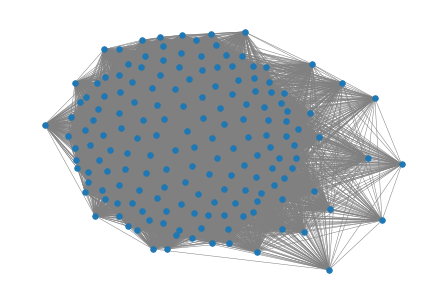

In [22]:
nx.draw_kamada_kawai(G, node_size = 30, edge_color = "gray", width = 0.5)

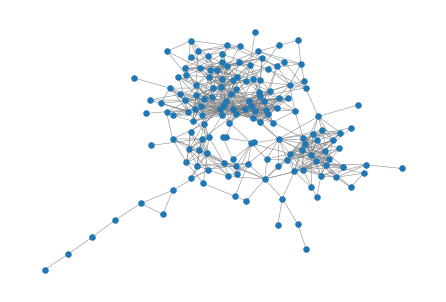

In [23]:
nx.draw_kamada_kawai(G_threshold, node_size = 30, edge_color = "gray", width = 0.5)

## Naive backboning

In [24]:
G, G_threshold, G_raw = backbone_network(network, "naive")

Calculating Naive score...


Threshold used is 60.9.

Number of original nodes pre-thresholding: 165
Number of original edges pre-thresholding: 12485 

Number of original nodes post-thresholding: 69
Number of original edges post-thresholding: 685 

Difference in nodes: 96
Difference in edges: 11800


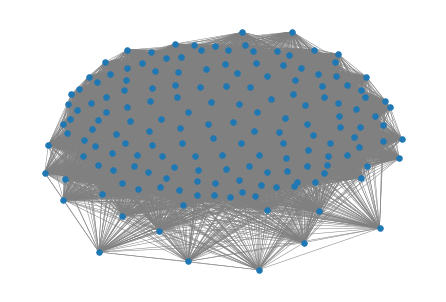

In [25]:
nx.draw_kamada_kawai(G, node_size = 30, edge_color = "gray", width = 0.5)

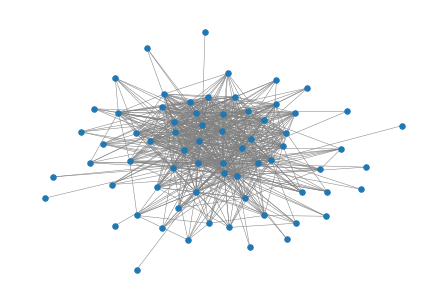

In [26]:
nx.draw_kamada_kawai(G_threshold, node_size = 30, edge_color = "gray", width = 0.5)

## Disparity filter backboning

In [27]:
G, G_threshold, G_raw = backbone_network(network, "disparity_filter")

Calculating DF score...


Threshold used is 0.9192.

Number of original nodes pre-thresholding: 165
Number of original edges pre-thresholding: 12485 

Number of original nodes post-thresholding: 141
Number of original edges post-thresholding: 682 

Difference in nodes: 24
Difference in edges: 11803


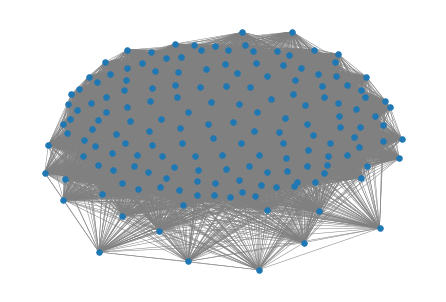

In [28]:
nx.draw_kamada_kawai(G, node_size = 30, edge_color = "gray", width = 0.5)

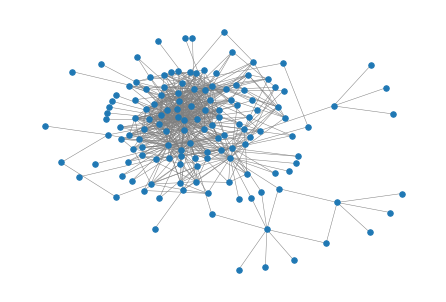

In [29]:
nx.draw_kamada_kawai(G_threshold, node_size = 30, edge_color = "gray", width = 0.5)

## Maximum spanning tree backboning

In [30]:
G, G_threshold, G_raw = backbone_network(network, "maximum_spanning_tree")

Threshold was NONE.
Number of original nodes pre-thresholding: 165
Number of original edges pre-thresholding: 12485 

Number of original nodes post-thresholding: 165
Number of original edges post-thresholding: 164 

Difference in nodes: 0
Difference in edges: 12321


Calculating MST score...


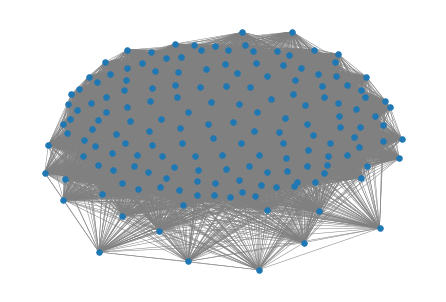

In [31]:
nx.draw_kamada_kawai(G_raw, node_size = 30, edge_color = "gray", width = 0.5)

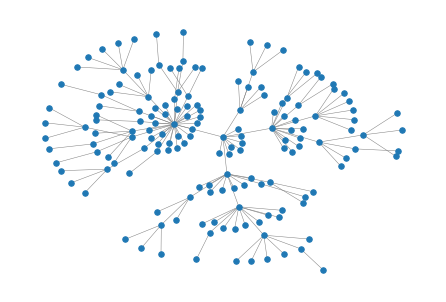

In [32]:
nx.draw_kamada_kawai(G, node_size = 30, edge_color = "gray", width = 0.5) #after backboning